In [2]:
# importing library
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
# need to merge both datasets
train = pd.read_csv("bigmart_train.csv") #train.shape = (8523, 12)
test = pd.read_csv("bigmart_test.csv") #test.shape = (5681, 11)
train["source"] = "train"
test["source"] = "test"
data = pd.concat([train, test], ignore_index=True)
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,train
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800,train
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,train


In [68]:
# get general statistics on the numerical columns
data.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,11765.000000,14204.000000,14204.000000,14204.000000,8523.000000
mean,12.792854,0.065953,141.004977,1997.830681,2181.288914
std,4.652502,0.051459,62.086938,8.371664,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.710000,0.027036,94.012000,1987.000000,834.247400
50%,12.600000,0.054021,142.247000,1999.000000,1794.331000
75%,16.750000,0.094037,185.855600,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [69]:
# find the null columns so that we can do data clensing
data.isnull().sum()

Item_Identifier                 0
Item_Weight                  2439
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  4016
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales            5681
source                          0
dtype: int64

In [70]:
# get unique values
print("Unique Values\n----------------")
print(data["Item_Fat_Content"].unique())
print(data["Outlet_Establishment_Year"].unique())
print(data["Outlet_Size"].unique())

# calculate outlet age
data["Outlet_Age"] = 2018 - data["Outlet_Establishment_Year"]
data.head(2)

Unique Values
----------------
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
[1999 2009 1998 1987 1985 2002 2007 1997 2004]
['Medium' nan 'High' 'Small']


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,source,Outlet_Age
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,train,19
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,train,9


In [71]:
# get the counts
print("Item fat content count\n----------------")
print(data["Item_Fat_Content"].value_counts())

print("\nOutlet size count\n----------------")
print(data["Outlet_Size"].value_counts())

Item fat content count
----------------
Low Fat    8485
Regular    4824
LF          522
reg         195
low fat     178
Name: Item_Fat_Content, dtype: int64

Outlet size count
----------------
Medium    4655
Small     3980
High      1553
Name: Outlet_Size, dtype: int64


In [72]:
# imputing missing values

# most common value "Medium" is replaced for missing values
print("Most common value in outlet size - %s" % data["Outlet_Size"].mode()[0])
data["Outlet_Size"] = data["Outlet_Size"].fillna(data["Outlet_Size"].mode()[0])

data["Item_Weight"] = data["Item_Weight"].fillna(data["Item_Weight"].mean())

Most common value in outlet size - Medium


(13943, 14)

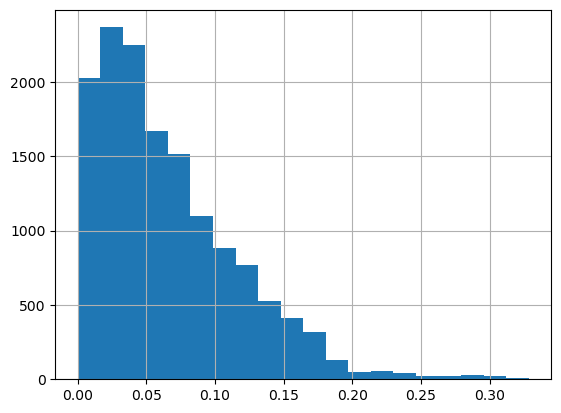

In [73]:
# detecting outliers in Item_Visibility column
data["Item_Visibility"].hist(bins=20)
q1 = data["Item_Visibility"].quantile(0.25)
q3 = data["Item_Visibility"].quantile(0.75)

# calculate inter quantile range
iqr = q3 - q1

# remove outlier data
fill_data = data.query('(@q1 - 1.5 * @iqr) <= Item_Visibility <= (@q3 + 1.5 * @iqr)')
data = fill_data
fill_data.shape

In [74]:
# converting Item_Visibility into categorical
data["Item_Visibility_bins"] = pd.cut(data["Item_Visibility"], [0.000, 0.065, 0.13, 0.2], ['Low Viz', 'Viz', 'High Viz'])
data["Item_Visibility_bins"] = data["Item_Visibility_bins"].replace(np.nan, 'Low Viz', regex=True)

# imputing correct values to Item_Fat_Content
data["Item_Fat_Content"] = data["Item_Fat_Content"].replace(["low fat", "LF"], "Low Fat")
data["Item_Fat_Content"] = data["Item_Fat_Content"].replace("reg", "Regular")
data["Item_Fat_Content"].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [75]:
# code all categorical variables into numeric
le = LabelEncoder()
data["Item_Fat_Content"] = le.fit_transform(data["Item_Fat_Content"])
data["Item_Visibility_bins"] = le.fit_transform(data["Item_Visibility_bins"])
data["Outlet_Size"] = le.fit_transform(data["Outlet_Size"])
data["Outlet_Location_Type"] = le.fit_transform(data["Outlet_Location_Type"])

In [76]:
# create dummies
outlet_type_dummy = pd.get_dummies(data["Outlet_Type"])
outlet_type_dummy.head(2)

,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
0,0,1,0,0
1,0,0,1,0


In [77]:
# combining Item_Identifier(code) to form 3 main categories as Food, Non-consumable, Drinks extracting first 2 chars in Item_Identifier
data["Item_Type_Combined"] = data["Item_Identifier"].apply(lambda x: x[0:2])
data["Item_Type_Combined"] = data["Item_Type_Combined"].map({"FD": "Food", "DR": "Drinks", "NC": "Non-Consumable"})
data["Item_Type_Combined"].value_counts()

Food              9991
Non-Consumable    2652
Drinks            1300
Name: Item_Type_Combined, dtype: int64

In [80]:
# perform one hot encoding for categorical data for prediection
cols_to_encode = ["Item_Fat_Content", "Outlet_Location_Type", "Outlet_Size", "Outlet_Type", "Item_Type_Combined"]
data = pd.get_dummies(data, columns=cols_to_encode)
data.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_Type                             object
Item_MRP                             float64
Outlet_Identifier                     object
Outlet_Establishment_Year              int64
Item_Outlet_Sales                    float64
source                                object
Outlet_Age                             int64
Item_Visibility_bins                   int32
Item_Fat_Content_0                     uint8
Item_Fat_Content_1                     uint8
Outlet_Location_Type_0                 uint8
Outlet_Location_Type_1                 uint8
Outlet_Location_Type_2                 uint8
Outlet_Size_0                          uint8
Outlet_Size_1                          uint8
Outlet_Size_2                          uint8
Outlet_Type_Grocery Store              uint8
Outlet_Type_Supermarket Type1          uint8
Outlet_Type_Supermarket Type2          uint8
Outlet_Typ

In [81]:
# clean columns that are not necessary
data.drop(["Item_Type", "Outlet_Establishment_Year"], axis=1, inplace=True)

# split into train and test datasets
train = data.loc[data["source"] == "train"]
test = data.loc[data["source"] == "test"]

# drop columns individually in each dataset
train.drop(["source"], axis=1, inplace=True)
test.drop(["source"], axis=1, inplace=True)

# export to csv
train.to_csv("bigmart_train_trans.csv", index=False)
test.to_csv("bigmart_test_trans.csv", index=False)

C:\Users\sujit\AppData\Local\Temp\ipykernel_8060\3593529118.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["source"], axis=1, inplace=True)
C:\Users\sujit\AppData\Local\Temp\ipykernel_8060\3593529118.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["source"], axis=1, inplace=True)


In [31]:
train2 = pd.read_csv("bigmart_train_trans.csv")
test2 = pd.read_csv("bigmart_test_trans.csv")
train2.dtypes

Item_Identifier                       object
Item_Weight                          float64
Item_Visibility                      float64
Item_MRP                             float64
Outlet_Identifier                     object
Item_Outlet_Sales                    float64
Outlet_Age                             int64
Item_Visibility_bins                   int64
Item_Fat_Content_0                     int64
Item_Fat_Content_1                     int64
Outlet_Location_Type_0                 int64
Outlet_Location_Type_1                 int64
Outlet_Location_Type_2                 int64
Outlet_Size_0                          int64
Outlet_Size_1                          int64
Outlet_Size_2                          int64
Outlet_Type_Grocery Store              int64
Outlet_Type_Supermarket Type1          int64
Outlet_Type_Supermarket Type2          int64
Outlet_Type_Supermarket Type3          int64
Item_Type_Combined_Drinks              int64
Item_Type_Combined_Food                int64
Item_Type_

In [32]:
# remove irrelavant data from train and test dataset
x_train = train2.drop(["Item_Outlet_Sales", "Outlet_Identifier", "Item_Identifier"], axis=1)
y_train = train2.Item_Outlet_Sales

x_test = test2.drop(["Outlet_Identifier", "Item_Identifier", "Item_Outlet_Sales"], axis=1)

In [33]:
# build the linear regression model
from sklearn import model_selection
from sklearn.linear_model import LinearRegression

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(x_train, y_train, test_size=0.3, random_state=42)
lm = LinearRegression()
lm.fit(xtrain, ytrain)
print("Coefficient - %s" % lm.coef_)
print("Intercept - %s" % lm.intercept_)

predict = lm.predict(xtest)
predict

Coefficient - [-1.88002412e+00 -3.96445130e+02  1.58765318e+01 -3.19586844e+01
  8.61125222e+00 -1.46995483e+00  1.46995483e+00  1.89141330e+02
  4.82636044e+01 -2.37404934e+02  5.40077820e+02 -3.11505169e+02
 -2.28572650e+02 -1.63474204e+03 -1.26569575e+02 -3.49159801e+02
  2.11047141e+03  8.49617720e+00  3.48179624e+01 -4.33141396e+01]
Intercept - 937.2230250583782


array([2082.02972074, 3698.89588652, 2956.77600268, ..., 3546.86113703,
       3464.79998827, 1254.07446594])

In [36]:
# find the model RMSE
import math
print("Mean squared error %s" % math.sqrt(mean_squared_error(ytest, predict)))

y_sales_pred = lm.predict(x_test)
test_predictions = pd.DataFrame({"Item_Identifier": test2["Item_Identifier"], "Outlet_Identifier": test2["Item_Identifier"], "Item_Outlet_Sales" : y_sales_pred})
test_predictions

Mean squared error 1125.956683443301


,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,FDW58,1784.890720
1,FDW14,FDW14,1587.651190
2,NCN55,NCN55,1849.511907
3,FDQ58,FDQ58,2670.763566
4,FDY38,FDY38,5136.737966
...,...,...,...
5563,FDB58,FDB58,2354.885255
5564,FDD47,FDD47,2419.491950
5565,NCO17,NCO17,1837.192703
5566,FDJ26,FDJ26,3636.673494
